# Deep Learning Assignment 1

In [3]:
import math
import matplotlib.pyplot as plt
import mnist
import random
import statistics as stat
from random import randint
from math import sqrt
import pstats
# -- assignment 1 --
import numpy as np
from urllib import request
import gzip
import pickle
import os

def load_synth(num_train=60_000, num_val=10_000, seed=0):
    """
    Load some very basic synthetic data that should be easy to classify. Two features, so that we can plot the
    decision boundary (which is an ellipse in the feature space).
    :param num_train: Number of training instances
    :param num_val: Number of test/validation instances
    :param num_features: Number of features per instance
    :return: Two tuples and an integer: (xtrain, ytrain), (xval, yval), num_cls. The first contains a matrix of training
     data with 2 features as a numpy floating point array, and the corresponding classification labels as a numpy
     integer array. The second contains the test/validation data in the same format. The last integer contains the
     number of classes (this is always 2 for this function).
    """
    np.random.seed(seed)

    THRESHOLD = 0.6
    quad = np.asarray([[1, -0.05], [1, .4]])

    ntotal = num_train + num_val

    x = np.random.randn(ntotal, 2)

    # compute the quadratic form
    q = np.einsum('bf, fk, bk -> b', x, quad, x)
    y = (q > THRESHOLD).astype(np.int)

    return (x[:num_train, :], y[:num_train]), (x[num_train:, :], y[num_train:]), 2

def load_mnist(final=False, flatten=True):
    """
    Load the MNIST data.
    :param final: If true, return the canonical test/train split. If false, split some validation data from the training
       data and keep the test data hidden.
    :param flatten: If true, each instance is flattened into a vector, so that the data is returns as a matrix with 768
        columns. If false, the data is returned as a 3-tensor preserving each image as a matrix.
    :return: Two tuples and an integer: (xtrain, ytrain), (xval, yval), num_cls. The first contains a matrix of training
     data and the corresponding classification labels as a numpy integer array. The second contains the test/validation
     data in the same format. The last integer contains the number of classes (this is always 2 for this function).
     """

    if not os.path.isfile('mnist.pkl'):
        init()

    xtrain, ytrain, xtest, ytest = load()
    xtl, xsl = xtrain.shape[0], xtest.shape[0]

    if flatten:
        xtrain = xtrain.reshape(xtl, -1)
        xtest  = xtest.reshape(xsl, -1)

    if not final: # return the flattened images
        return (xtrain[:-5000], ytrain[:-5000]), (xtrain[-5000:], ytrain[-5000:]), 10

    return (xtrain, ytrain), (xtest, ytest), 10

# Numpy-only MNIST loader. Courtesy of Hyeonseok Jung
# https://github.com/hsjeong5/MNIST-for-Numpy

filename = [
["training_images","train-images-idx3-ubyte.gz"],
["test_images","t10k-images-idx3-ubyte.gz"],
["training_labels","train-labels-idx1-ubyte.gz"],
["test_labels","t10k-labels-idx1-ubyte.gz"]
]

def download_mnist():
    base_url = "http://yann.lecun.com/exdb/mnist/"
    for name in filename:
        print("Downloading "+name[1]+"...")
        request.urlretrieve(base_url+name[1], name[1])
    print("Download complete.")

def save_mnist():
    mnist = {}
    for name in filename[:2]:
        with gzip.open(name[1], 'rb') as f:
            mnist[name[0]] = np.frombuffer(f.read(), np.uint8, offset=16).reshape(-1,28*28)
    for name in filename[-2:]:
        with gzip.open(name[1], 'rb') as f:
            mnist[name[0]] = np.frombuffer(f.read(), np.uint8, offset=8)
    with open("mnist.pkl", 'wb') as f:
        pickle.dump(mnist,f)
    print("Save complete.")

def init():
    download_mnist()
    save_mnist()

def load():
    with open("mnist.pkl",'rb') as f:
        mnist = pickle.load(f)
    return mnist["training_images"], mnist["training_labels"], mnist["test_images"], mnist["test_labels"]

In [4]:
def sigmoid(z):
    if z>=0:
        return 1/(1+math.exp(-z))
    else:
        return math.exp(z)/(1+math.exp(z))

def softmax(x): 
    total_sum = sum([math.exp(item) for item in x])
    row = []
    for item in x:
        row.append(math.exp(item)/total_sum)
    return row

def transpose(x):
    return list(map(list, zip(*x)))

def loss_function(y, t):
    l = 0
    for i in range(len(y)):
        l += t[i]*(-math.log(y[i]))
    return l

In [5]:
W = [[1., 1., 1.], [-1., -1., -1.]]
V = [[1.,1.],[-1.,-1.],[-1.,-1.]]
b = [0.,0.,0.]
c = [0.,0.]
X = [1, -1]
Y = [1, 0]
param = W, b, V, c

In [6]:
def propagate(param, X, t):
    
    W, b, V, c = param
    
    # Forward Layer
    k = [sum([x*y for x,y in zip(X,row)]) for row in transpose(W)]
    k = [i+j for i ,j in zip(k, b)]
    h = [sigmoid(i) for i in k]
    
    ## Second layer:
    o = [sum([x*y for x,y in zip(h,row)]) for row in transpose(V)]
    o = [i+j for i,j in zip(o, c)]
    y = softmax(o)
    cost = loss_function(y, t)
    
   
    do = [i-j for i,j in zip(y,t)]
    dc = do
    dV = [[i*y for i in do] for y in h] 
    dh = [sum([x*y for x,y in zip(do,row)]) for row in V]
    dz = [i*(1-i) for i in h]
    dz = [x*y for x,y in zip(dz, dh)] # ?
    dW = [[i*y for y in dz] for i in X]
    db = dz

    grads = (dW, db, dV, dc)    
    
    return grads, cost, y
    

In [7]:
%%time
param = (W, b, V, c)
grads, cost, y_pred = propagate(param, X, Y)

Wall time: 0 ns


In [8]:
grads

([[0.0, 0.0, 0.0], [-0.0, -0.0, -0.0]],
 [0.0, 0.0, 0.0],
 [[-0.44039853898894116, 0.44039853898894116],
  [-0.44039853898894116, 0.44039853898894116],
  [-0.44039853898894116, 0.44039853898894116]],
 [-0.5, 0.5])

## Q3 Show that the loss decreases

In [9]:
def update_param(param, grads, alpha):
    W, b, V, c = param
    dW, db, dV, dc = grads

    W = [[i-alpha*j for i,j in zip(p,r)] for p,r in zip(W, dW)]
    b = [i-alpha*j for i,j in zip(b, db)]
    V = [[i-alpha*j for i,j in zip(p,r)] for p,r in zip(V, dV)]
    c = [i-alpha*j for i,j in zip(c, dc)]
    param = W, b, V, c
    
    return param

In [10]:
alpha = 0.01
loss_record = []
W = [[1., 1., 1.], [-1., -1., -1.]]
V = [[1.,1.],[-1.,-1.],[-1.,-1.]]
b = [0.,0.,0.]
c = [0.,0.]
X = [1, -1]
Y = [1, 0]

param = (W, b, V, c)
for i in range(100):
    grads, loss, y_pred = propagate(param, X, Y)
    param = update_param(param, grads, alpha)
    if i % 10 == 0:
        loss_record.append(loss)
        print ("Loss after iteration %i: %f" %(i, loss))

Loss after iteration 0: 0.693147
Loss after iteration 10: 0.550533
Loss after iteration 20: 0.447715
Loss after iteration 30: 0.372284
Loss after iteration 40: 0.315725
Loss after iteration 50: 0.272353
Loss after iteration 60: 0.238377
Loss after iteration 70: 0.211237
Loss after iteration 80: 0.189177
Loss after iteration 90: 0.170966


Text(0.5, 0, 'iteration')

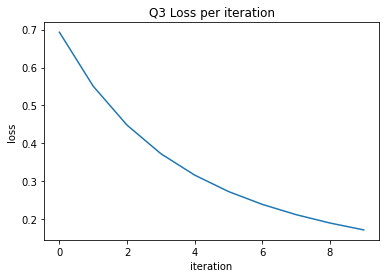

In [11]:
plt.plot(loss_record)  
plt.title("Q3 Loss per iteration")
plt.ylabel("loss")
plt.xlabel("iteration")

## Q4 

In [12]:
(xtrain, ytrain), (xval, yval), num_cls = load_synth()
targets = []
for item in ytrain:
    if item == 0:
        row = [1,0]
    else:
        row = [0,1]
    targets.append(row)

t_test = []
for item in yval:
    if item == 1:
        row = [1,0]
    else:
        row = [0,1]
    t_test.append(row)


C:\Users\CLUBBI~1\AppData\Local\Temp/ipykernel_16264/101678582.py:39: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y = (q > THRESHOLD).astype(np.int)


In [13]:

costs = []
epoch_costs = []
alpha = 0.01

W = [np.random.normal(0,1/sqrt(3),3).tolist(), np.random.normal(0,1/sqrt(3),3).tolist()]
V = [np.random.normal(0,1/sqrt(3),2).tolist(), np.random.normal(0,1/sqrt(3),2).tolist(), np.random.normal(0,1/sqrt(3),2).tolist()]
b = [0.,0.,0.]
c = [0.,0.]

track = []
dump = []
smooth = []
param = W, b, V, c

for e in range(6):
    for i in range(len(xtrain)):
        grads, loss, y_pred = propagate(param, xtrain[i], targets[i])
        param = update_param(param, grads, alpha)
        dump.append(loss)
        costs.append(loss)
        if (i+1)%1000 == 0:
            smooth.append(sum(dump)/1000)
            dump = []
    mean_loss = sum(costs)/len(xtrain)
    epoch_costs.append(mean_loss)
    costs = []
    print("Epoch: " + str(e) + " Mean loss: " + str(mean_loss))

Epoch: 0 Mean loss: 0.39974426737366225
Epoch: 1 Mean loss: 0.13334752733005695
Epoch: 2 Mean loss: 0.10763725076542904
Epoch: 3 Mean loss: 0.09886257894787441
Epoch: 4 Mean loss: 0.09215199570630836
Epoch: 5 Mean loss: 0.08644934630243509


In [14]:
param

([[5.673792135868482, 4.598235826592304, 1.7059322543344007],
  [2.264374773271626, 4.0381438320465985, -1.8607786515721298]],
 [-3.60498340126389, 3.6273165100255973, 2.1972493581196075],
 [[-8.23667717345309, 8.961321808689613],
  [7.940452700276817, -7.67793154063449],
  [5.934175380146133, -6.555328940559287]],
 [-8.202754142101805, 8.202754142101812])

Text(0.5, 1.0, 'Mean loss per 1000 samples')

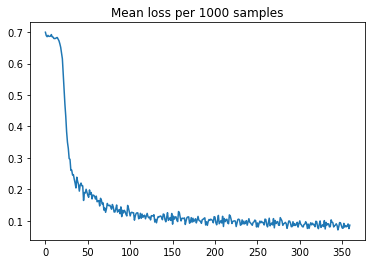

In [15]:
plt.plot(smooth)
plt.title("Mean loss per 1000 samples")

Text(0.5, 1.0, 'Mean training loss per epoch')

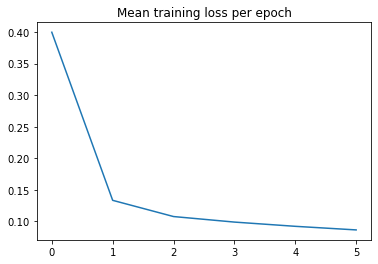

In [16]:
import matplotlib.pyplot as plt
plt.plot(epoch_costs)
plt.title("Mean training loss per epoch")

## Q5

In [63]:
#(xtrain, ytrain), (xtest, ytest), num = load_mnist
mnist.init()
(xtrain, ytrain), (xval, yval), num_cls = load_mnist(final=True)
xtrain = xtrain/255
xval = xval/255
def one_hot_encode(data):
    temp = np.zeros((data.size, 10))
    temp[np.arange(data.size), data] = 1
    return temp

t_train = one_hot_encode(ytrain)
t_test = one_hot_encode(yval)

Download complete.
Save complete.


In [64]:
def initialize_parameters_deep(layer_dims):
    """
    Arguments:
    layer_dims -- python array (list) containing the dimensions of each layer in our network
    
    Returns:
    parameters -- W, b, V, c, where W and V are weight matrices and b,c represents the bias respectively.
    """
    np.random.seed(3)
    x_size, h_size, o_size = layer_dims
         
    W = np.random.normal(0, 1, size=(h_size,x_size))
    b = np.zeros((h_size,1))
    V = np.random.normal(0, 1, size=(o_size,h_size))
    c = np.zeros((o_size,1))
    parameters = W,b,V,c
        
    return parameters

In [65]:
def sigmoid(x):
    return 1/(1+np.exp(-x))

def softmax(x):
    return np.exp(x)/sum(np.exp(x))
    
def forward(x, t, params):
    W, b, V, c = params
    z = W@x + b 
    h = sigmoid(z)
    o = V@h + c
    y = softmax(o)
    loss = -math.log((y.T@t)[0][0])
    params = W, b, V, c
    cache = z, h, o
    return params, loss, y, cache

def backward(x, t, params, y, cache):
    W, b, V, c = params
    z, h, o = cache
    gy = t * (-1/y)
    go = (-y@y.T + np.diagflat(y)) @ gy
    gc = go
    gV = go @ h.T
    gh = V.T @ go
    gz = gh * h * (1-h)
    gW = gz @ x.T
    gb = gz
    
    grads = gW, gb, gV, gc
    
    return grads

def SGD(x,t,params,alpha=1e-2):
    params, loss, y, cache = forward(x, t, params)
    grads = backward(x, t, params, y, cache)
    gW, gb, gV, gc = grads
    W, b, V, c = params
    W -= alpha * gW
    b -= alpha * gb
    V -= alpha * gV
    c -= alpha * gc
    params = W, b, V, c
    return params, loss, y

In [66]:
def sigmoid(x):
    return 1/(1+np.exp(-x))

def softmax(x):
    return np.exp(x)/sum(np.exp(x))
    
def forward(x, t, params):
    W, b, V, c = params
    z = np.matmul(W,x) + b 
    h = sigmoid(z)
    o = np.matmul(V,h) + c
    y = softmax(o)
    loss = -math.log((np.matmul(y.T,t)[0][0]))
    params = W, b, V, c
    cache = z, h, o
    return params, loss, y, cache

def backward(x, t, params, y, cache):
    W, b, V, c = params
    z, h, o = cache
    #gy = t * (-1/y)
    #go = (-y@y.T + np.diagflat(y)) @ gy
    go = y-t
    gc = go
    gV = np.matmul(go,h.T)
    gh = np.matmul(V.T, go)
    gz = gh * h * (1-h)
    gW = np.matmul(gz, x.T)
    gb = gz
    
    grads = gW, gb, gV, gc
    
    return grads

def SGD(x,t,params,alpha=1e-2):
    params, loss, y, cache = forward(x, t, params)
    grads = backward(x, t, params, y, cache)
    gW, gb, gV, gc = grads
    W, b, V, c = params
    W -= alpha * gW
    b -= alpha * gb
    V -= alpha * gV
    c -= alpha * gc
    params = W, b, V, c
    return params, loss, y

def getAccuracy(x, t, params):
    total = x.shape[0]
    num_correct = 0
    for i in range(total):
        params, loss, y, cache = forward(x[i][:,None], t[i][:,None], params)
        prediction = np.argmax(y)
        target = np.argmax(t[i,:])
        if target == prediction:
            num_correct += 1
    return num_correct/total * 100

In [105]:
len(xtrain)

60000

In [118]:
%%time
params = initialize_parameters_deep([784,300,10])
trainloss= []
valloss = []
num_train = 60000
num_test = len(xval)
for e in range(5):
    for n in range(num_train):
        m = random.randint(0,num_train-1)
        k = random.randint(0,num_test-1)
        params, loss, y = SGD(xtrain[m][:,None], t_train[m,:][:,None], params, 0.003) 
        #params, loss, y, cache = forward(xtrain[0][:,None], t_train[0][:,None], params)
        valloss.append(forward(xval[k,:][:,None], t_test[k,:][:,None], params)[1] )
        trainloss.append(loss)
    print("Done.")
print(getAccuracy(xval, t_test, params))

Done.
Done.
Done.
Done.
Done.
91.55
Wall time: 8min 52s


Text(0.5, 0, 'Iterations')

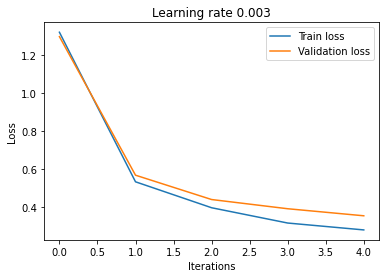

In [120]:
averagedtrainloss=[]      
averagedvalloss=[]  
for i in range(5):
    averagedtrainloss.append(stat.mean(trainloss[i*60000:(i+1)*60000]))
    averagedvalloss.append(stat.mean(valloss[i*60000:(i+1)*60000]))

plt.plot(averagedtrainloss, label="Train loss")
plt.plot(averagedvalloss, label="Validation loss")
plt.title("Learning rate 0.003")
plt.legend()
plt.ylabel("Loss")
plt.xlabel("Iterations")

## Confidence interval cross entropy loss for three models

In [149]:
params1 = initialize_parameters_deep([784,300,10])
params2 = initialize_parameters_deep([784,300,10])
params3 = initialize_parameters_deep([784,300,10])
trainloss1 = []
trainloss2 = []
trainloss3 = []
valloss1 = []
valloss2 = []
valloss3 = []
acc1 = []
acc2 = []
acc3 = []
num_train = 55000
num_test = len(xval)
for e in [1,2,3,4,5]:
    for n in range(num_train):
        m = random.randint(0,num_train-1)
        k = random.randint(0,num_test-1)
        params1, loss1, y1 = SGD(xtrain[m][:,None], t_train[m,:][:,None], params1, 0.01) 
        valloss1.append(backprop(xval[k,:][:,None], t_test[k,:][:,None], params1)[1] )
        trainloss1.append(loss1)

        m = random.randint(0,num_train-1)
        k = random.randint(0,num_test-1)
        params2, loss2, y2 = SGD(xtrain[m][:,None], t_train[m,:][:,None], params2, 0.01) 
        valloss2.append(backprop(xval[k,:][:,None], t_test[k,:][:,None], params2)[1] )
        trainloss2.append(loss2)

        m = random.randint(0,num_train-1)
        k = random.randint(0,num_test-1)
        params3, loss3, y3 = SGD(xtrain[m][:,None], t_train[m,:][:,None], params3, 0.01) 
        valloss3.append(backprop(xval[k,:][:,None], t_test[k,:][:,None], params3)[1] )
        trainloss3.append(loss3)
    acc1 = getAccuracy(xval, t_test, params1)
    acc2 = getAccuracy(xval, t_test, params2)
    acc3 = getAccuracy(xval, t_test, params3)

In [179]:
np.mean(valloss3)
np.std(valloss1)
valloss1 = np.array(valloss1)
valloss2 = np.array(valloss2)
valloss3 = np.array(valloss3)
trainloss1 = np.array(trainloss1)
trainloss2 = np.array(trainloss2)
trainloss3 = np.array(trainloss3)

[1.54904474 0.78075271 0.68974808 0.66282287 0.61182854]


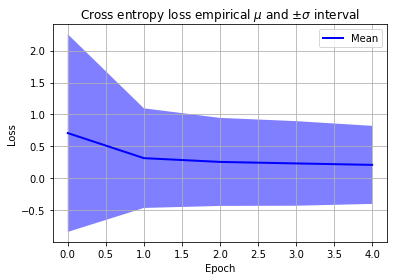

In [186]:
#np.mean(valloss1.reshape((5,55000)), axis=1)
mu1 = np.mean(valloss1.reshape((5,55000)), axis=1)
mu2 = np.mean(valloss2.reshape((5,55000)), axis=1)
mu3 = np.mean(valloss3.reshape((5,55000)), axis=1)

#sigma = np.std(((np.array(trainloss1) + np.array(trainloss2) + np.array(trainloss3))/3).reshape((5,55000)), axis=1)
mu = np.mean(np.array((mu1,mu2,mu3)), axis = 0)
#print(mu)
sigma = np.std(((np.array(valloss1) + np.array(valloss2) + np.array(valloss3))/3).reshape((5,55000)), axis=1)

print(sigma)

t = np.arange(5)
# plot it!
fig, ax = plt.subplots(1)
ax.plot(t, mu, lw=2, label='Mean', color='blue')
ax.fill_between(t, mu+sigma, mu-sigma, facecolor='blue', alpha=0.5)

ax.set_title(r'Cross entropy loss empirical $\mu$ and $\pm \sigma$ interval')
ax.legend(loc='upper right')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.grid()



(5,)


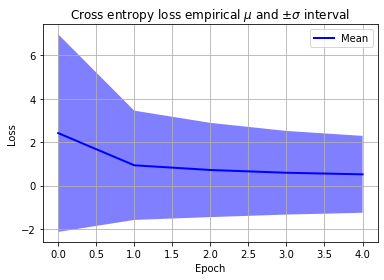

In [73]:
mu = np.mean(np.array(trainloss).reshape((5,55000)), axis = 1)
#print(mu)
sigma = np.std(np.array(trainloss).reshape((5,55000)), axis=1)

print(mu.shape)

t = np.arange(5)
# plot it!
fig, ax = plt.subplots(1)
ax.plot(t, mu, lw=2, label='Mean', color='blue')
ax.fill_between(t, mu+sigma, mu-sigma, facecolor='blue', alpha=0.5)

ax.set_title(r'Cross entropy loss empirical $\mu$ and $\pm \sigma$ interval')
ax.legend(loc='upper right')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.grid()

Text(0.5, 0, 'Iterations')

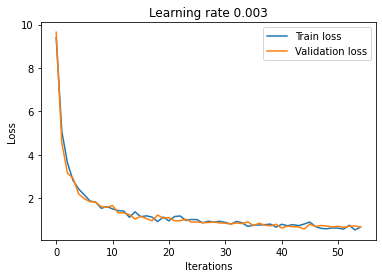

In [98]:
averagedtrainloss=[]      
averagedvalloss=[]  
for i in range(55):
    averagedtrainloss.append(stat.mean(trainloss[i*1100:(i+1)*1100]))
    averagedvalloss.append(stat.mean(valloss[i*1100:(i+1)*1100]))

plt.plot(averagedtrainloss, label="Train loss")
plt.plot(averagedvalloss, label="Validation loss")
plt.title("Learning rate 0.003")
plt.legend()
plt.ylabel("Loss")
plt.xlabel("Iterations")

Text(0.5, 0, 'Iterations')

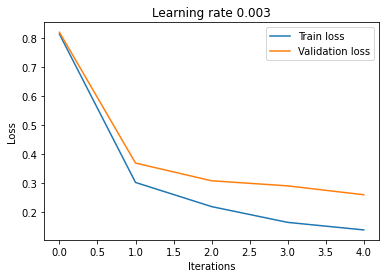

In [101]:
averagedtrainloss=[]      
averagedvalloss=[]  
for i in range(5):
    averagedtrainloss.append(stat.mean(trainloss[i*55000:(i+1)*55000]))
    averagedvalloss.append(stat.mean(valloss[i*55000:(i+1)*55000]))

plt.plot(averagedtrainloss, label="Train loss")
plt.plot(averagedvalloss, label="Validation loss")
plt.title("Learning rate 0.003")
plt.legend()
plt.ylabel("Loss")
plt.xlabel("Iterations")

In [110]:
getAccuracy(xval, t_test, params)

91.75999999999999

Text(0.5, 0, 'Iterations')

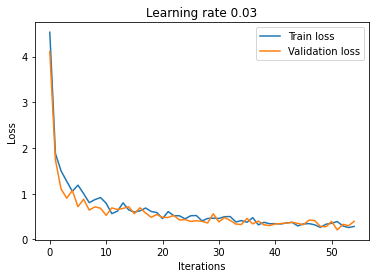

In [76]:
averagedtrainloss=[]      
averagedvalloss=[]  
for i in range(55):
    averagedtrainloss.append(stat.mean(trainloss[i*1000:(i+1)*1000]))
    averagedvalloss.append(stat.mean(valloss[i*1000:(i+1)*1000]))

plt.plot(averagedtrainloss, label="Train loss")
plt.plot(averagedvalloss, label="Validation loss")
plt.title("Learning rate 0.03")
plt.legend()
plt.ylabel("Loss")
plt.xlabel("Iterations")

In [22]:
def getAccuracy(x, t, params):
    """
    Obtain the accuracy of the model on a validation set or test set
    """
    total = x.shape[0]
    num_correct = 0
    for i in range(total):
        params, loss, y, cache = forward(x[i][:,None], t[i][:,None], params)
        prediction = np.argmax(y)
        target = np.argmax(t[i,:])
        if target == prediction:
            num_correct += 1
    return num_correct/total * 100

#getAccuracy(xval, t_test, params)

## Q6

In [51]:
def tensorforward(x, t, params, batch_size):
    W, b, V, c = params
    z = W@x + b 
    h = np.apply_along_axis(sigmoid, 1, z)
    #print(z.shape)
    #h = sigmoid(z)
    o = V@h + c
    #y = softmax(o)
    #print(o.shape)
    y = np.apply_along_axis(softmax, 1, o )
    loss = -np.log((y.reshape((batch_size,1,10))@t).squeeze())
    loss = np.mean(loss)
    cache = z, h, o
    return loss, y, cache

def tensorbackward(x, t, params, y, cache, batch_size):
    W, b, V, c = params
    z, h, o = cache
    #gy = t * (-1/y)
    #temp = np.apply_along_axis(np.diagflat, 1, y.squeeze())
    #go = (-y@y.reshape((batch_size,1,10)) + temp) @ gy
    go = y-t
    gc = go
    gV = go @ h.reshape((batch_size,1,300)) #.T
    gh = V.T @ go
    gz = gh * h * (1-h)
    gW = gz @ x.reshape((batch_size,1,784)) #.T
    gb = gz
    
    grads = np.mean(gW, axis = 0), np.mean(gb, axis = 0), np.mean(gV, axis = 0), np.mean(gc, axis = 0)
    
    return grads

def minibatchGD(x_batch, t_batch, params, batch_size, alpha=1e-2):
    batchsize = x_batch.shape[0]
    x = x_batch[:, :, None]
    t = t_batch[:, :, None]
    loss, y, cache = tensorforward(x, t, params, batch_size)
    grads = tensorbackward(x, t, params, y, cache, batch_size)
    gW, gb, gV, gc = grads
    
    W, b, V, c = params
    W -= alpha * gW
    b -= alpha * gb
    V -= alpha * gV
    c -= alpha * gc
    params = W, b, V, c
    return params, loss, y

In [49]:
%time for n in range(5500): trainloss.append(loss)

Wall time: 998 µs


In [69]:
%%time
track = []
trainloss= []
valloss = []
num_train = 55000
num_test = len(xval)
params = initialize_parameters_deep([784,300,10])
batch_size = 10

## Minibatch Gradient Descent loop ################################
for e in range(5):
    for n in range(5500):
        x_batch = xtrain[batch_size*n:batch_size*(n+1),:][0:batch_size, :]
        t_batch = t_train[batch_size*n:batch_size*(n+1),:][0:batch_size, :]
        params, loss, y = minibatchGD(x_batch, t_batch, params, batch_size, 0.01)
        trainloss.append(loss)
    track.append(trainloss)
    trainloss = []


KeyboardInterrupt: 

In [68]:
getAccuracy(xval, t_test, params)

90.93

In [20]:
averagedtrainloss=[] 
for i in range(55):
    averagedtrainloss.append(stat.mean(trainloss[i*1000:(i+1)*1000]))
plt.plot(averagedtrainloss, label="Validation loss")
plt.legend()
plt.ylabel("Loss")
plt.xlabel("Iterations")

StatisticsError: mean requires at least one data point

Text(0.5, 0, 'Iterations')

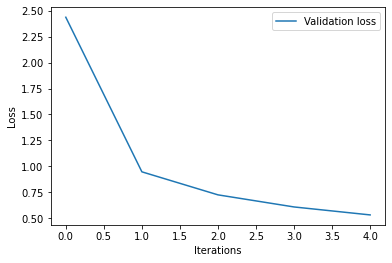

In [57]:
plt.plot(np.mean(np.array(track), axis=1), label="Validation loss")
plt.legend()
plt.ylabel("Loss")
plt.xlabel("Iterations")

In [31]:
getAccuracy(xval, t_test, params)

9.78